# <p align="center">Multi-Pattern CAVs Cross Correlation Invariance</p>

In this 2D Toy Experiment, we illustrate the behaviour of concept directions obtained from multi-Pattern CAV solution under changing cross-concept correlations given a linear generative model.

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


First, we define the data generation and visualization functions. Here the underlying generation process uses 2 concepts - each of which is aligned with a standart basis vector of $\mathbb{R}^2$:

In [67]:
from dataclasses import dataclass
from pathlib import Path
from typing import Tuple, Dict

torch.manual_seed(42)
np.random.seed(42)

@dataclass
class ToyData:
    X: torch.Tensor               # (n, 2)
    Y: torch.Tensor               # (n, 2) binary labels
    meta: Dict[str, float]        # parameters used to generate the data

def generate_toy_2d(
    n: int = 600,
    p1: float = 0.45,                    # P(y1=1)
    p2: float = 0.40,                    # P(y2=1)
    corr_labels: torch.Tensor = None,    # (2,2) correlation for label GP (required for dependence)
    corr_features: torch.Tensor = None,  # (2,2) correlation for feature noise (optional)
    noise_scale: float = 0.2,
    strength1: float = 1.0,             # signal strength for concept 1
    strength2: float = 1.0,             # signal strength for concept 2
    offset: Tuple[float, float] = (2.0, 2.0),
    device: str = "cpu"
) -> ToyData:
    """
    Generate a 2D toy dataset where *labels are coupled* via a 2D Gaussian (probit / Gaussian copula)
    with a specified correlation matrix. Features are then created as a linear signal of the two
    concepts plus *correlated Gaussian* noise controlled by corr_features.

    Label model (Gaussian copula / probit):
        z ~ N(0, corr_labels),   y_i = 1{ z_i > Phi^{-1}(1 - p_i) },  i=1,2
      => P(y_i=1)=p_i (exact), dependence governed by corr_labels.

    Feature model:
        X = y1 * strength1 * e1 + y2 * strength2 * e2 + eps,
        eps ~ N(0, corr_features) * noise_scale

    Returns:
        ToyData(X: (n,2), Y: (n,2), meta: dict)
    """

    # --- Defaults & validation for correlation matrices ---
    if corr_labels is None:
        raise ValueError("corr_labels must be provided as a 2x2 correlation matrix for the 2D Gaussian process.")
    corr_labels = torch.as_tensor(corr_labels, dtype=torch.float32, device=device)
    if corr_labels.shape != (2, 2):
        raise ValueError(f"corr_labels must have shape (2,2), got {tuple(corr_labels.shape)}.")
    if not torch.allclose(torch.diag(corr_labels), torch.ones(2, device=device), atol=1e-6):
        raise ValueError("corr_labels must have ones on its diagonal.")
    # PSD check (allow tiny negative eigenvalues due to num. issues)
    if torch.linalg.eigvalsh(corr_labels).min() < -1e-8:
        print(corr_labels)
        raise ValueError("corr_labels must be positive semidefinite.")

    if corr_features is None:
        corr_features = torch.eye(2, device=device)
    else:
        corr_features = torch.as_tensor(corr_features, dtype=torch.float32, device=device)
        if corr_features.shape != (2, 2):
            raise ValueError(f"corr_features must have shape (2,2), got {tuple(corr_features.shape)}.")
        if not torch.allclose(torch.diag(corr_features), torch.ones(2, device=device), atol=1e-6):
            raise ValueError("corr_features must have ones on its diagonal.")
        if torch.linalg.eigvalsh(corr_features).min() < -1e-8:
            raise ValueError("corr_features must be positive semidefinite.")

    # --- Sample labels via a 2D Gaussian process (Gaussian copula / probit link) ---
    # thresholds to match desired marginals exactly
    std_normal = torch.distributions.Normal(loc=0.0, scale=1.0)
    t1 = std_normal.icdf(torch.tensor(1.0 - p1, device=device, dtype=torch.float32))
    t2 = std_normal.icdf(torch.tensor(1.0 - p2, device=device, dtype=torch.float32))

    L_lbl = torch.linalg.cholesky(corr_labels)
    z = torch.randn(n, 2, device=device) @ L_lbl.T
    y1 = (z[:, 0] > t1).float().unsqueeze(1)
    y2 = (z[:, 1] > t2).float().unsqueeze(1)
    Y = torch.cat([y1, y2], dim=1)  # (n,2)

    # Ensure all four label combinations appear at least once (optional but handy for demos)
    combos = {(0,0): False, (1,0): False, (0,1): False, (1,1): False}
    for i in range(n):
        tup = (int(Y[i,0].item()), int(Y[i,1].item()))
        combos[tup] = True
    idx = 0
    for tup, ok in combos.items():
        if not ok and idx < n:
            Y[idx,0] = tup[0]
            Y[idx,1] = tup[1]
            idx += 1

    # --- Build features from concepts + correlated Gaussian noise ---
    e1 = torch.tensor([1.0, 0.0], device=device)
    e2 = torch.tensor([0.0, 1.0], device=device)

    mean_part = (Y[:, [0]] * strength1) * e1 + (Y[:, [1]] * strength2) * e2  # (n,2)

    L_feat = torch.linalg.cholesky(corr_features)
    eps = (torch.randn(n, 2, device=device) @ L_feat.T) * noise_scale

    # Shift samples to first quadrant for clearer visualization; concept axes remain at origin
    X = mean_part + eps + torch.tensor(offset, device=device, dtype=torch.float32)

    meta = dict(
        n=n, p1=p1, p2=p2,
        corr_labels=corr_labels.detach().cpu().tolist(),
        corr_features=corr_features.detach().cpu().tolist(),
        noise_scale=noise_scale,
        strength1=strength1, strength2=strength2,
        offset=offset
    )
    return ToyData(X=X, Y=Y, meta=meta)


def visualize_toy_2d(
    data: ToyData,
    title: str = "2D Toy Data (two concepts)",
    scale: float = 1.0,                 # scaling for arrow length
    cavs: torch.Tensor = None,          # optional: (2, n_features)
    cav_pos: tuple[float, float] | None = None, # CAV positioning (optional)
    save_dir: Path | str | None = None, # folder to save figure
    filename: str = "toy2d.png"         # filename to save
) -> None:
    """Scatter plot of 2D toy data grouped by concept labels, with consistent color scheme and CAV visualization."""
    X = data.X.cpu().numpy()
    Y = data.Y.cpu().numpy()

    # --- Colors ---
    COL_C1   = "#5880A0"
    COL_C2   = "#785964"
    COL_BOTH = "#696d83"
    COL_NONE = "#B3B3B3"

    # --- Masks (all markers 'o') ---
    masks = {
        "none (0,0)"     : ((Y[:,0]==0) & (Y[:,1]==0), COL_NONE),
        "concept 1 (1,0)": ((Y[:,0]==1) & (Y[:,1]==0), COL_C1),
        "concept 2 (0,1)": ((Y[:,0]==0) & (Y[:,1]==1), COL_C2),
        "both (1,1)"     : ((Y[:,0]==1) & (Y[:,1]==1), COL_BOTH),
    }

    plt.figure(figsize=(6.5, 6.0))
    for label, (m, c) in masks.items():
        plt.scatter(X[m, 0], X[m, 1], marker='o', color=c, alpha=0.8, label=label, edgecolors='none')

    # --- Standard basis e_1, e_2 ---
    plt.quiver(0, 0, 1.0, 0.0, angles='xy', scale_units='xy', scale=1.0, width=0.005, color='black')
    plt.quiver(0, 0, 0.0, 1.0, angles='xy', scale_units='xy', scale=1.0, width=0.005, color='black')
    plt.text(1.05, 0.0, r"$e_1$", ha='left', va='bottom', color='black', fontweight='bold')
    plt.text(0.0, 1.05, r"$e_2$", ha='left', va='bottom', color='black', fontweight='bold')

    # --- Draw CAVs if provided ---
    if cavs is not None:
        cavs_np = cavs.detach().cpu().numpy()
        if cavs_np.shape == (2, 2):
            startx, starty = (data.meta.get("offset", (0.0, 0.0)) 
                            if cav_pos is None else cav_pos)
            cav_colors = [COL_C1, COL_C2]
            cav_labels = [r"$c_1$", r"$c_2$"]
            for i, vec in enumerate(cavs_np):
                dx, dy = vec[0]*scale, vec[1]*scale
                plt.quiver(startx, starty, dx, dy,
                        angles='xy', scale_units='xy', scale=1.0,
                        width=0.007, color=cav_colors[i])
                plt.text(startx + dx*1.05, starty + dy*1.05,
                        cav_labels[i], ha='left', va='bottom', color='black', fontweight='bold')
        else:
            print(f"[visualize_toy_2d] Expected cavs of shape (2, 2), got {cavs_np.shape} — skipping arrows.")

    plt.title(title)
    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend(loc='upper left', frameon=False)
    plt.grid(False)
    plt.xlim(-0.5, 4.9)
    plt.ylim(-0.5, 4.9)
    # plt.axis('equal')

    # --- Save figure ---
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        out_path = save_dir / filename
        plt.savefig(out_path, format="pdf")
    
    plt.show()

## 2D Toy Experiment

We start by generating a toy set using a set of different cross-concept correlations. Then we fit both Pattern and multi-Pattern CAVs into it to see how both behave as the cross-concept correlation increases.

In [81]:
cross_correlations = [0.1, 0.3, 0.5, 0.7, 0.9]
save_dir = Path(Path.cwd().resolve().parent) / 'media' / 'cross_correlation_invariance'
datasets = []

for phi in cross_correlations:
    # Correlation between labels
    corr_labels = torch.tensor([
        [1.0, phi],  
        [phi, 1.0]
    ])

    # Feature noise correlation
    corr_features = torch.tensor([
        [1.0, 0.1],    # weak correlation between feature noise dimensions
        [0.1, 1.0]
    ])

    # Generate dataset
    toy = generate_toy_2d(
        n=600,
        p1=0.5,                 # 50% of samples have concept 1 active
        p2=0.4,                 # 40% have concept 2 active
        corr_labels=corr_labels,   # correlation among labels
        corr_features=corr_features,  # correlation in feature noise
        noise_scale=0.25,
        strength1=1.4,
        strength2=1.6,
        offset=(2.0, 2.0)
    )
    datasets.append(toy)

### 1. Pattern-CAV

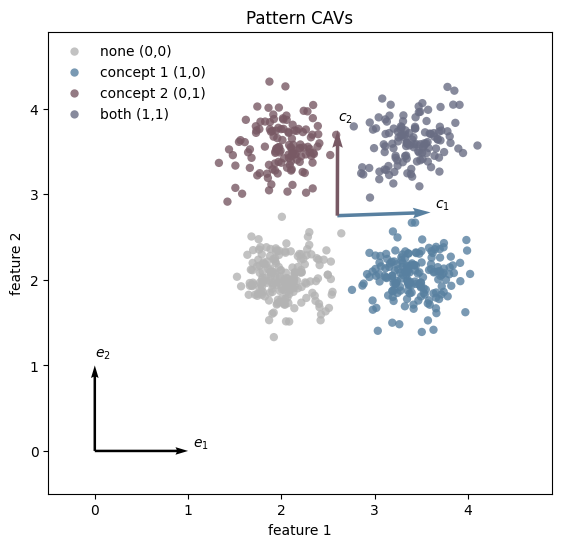

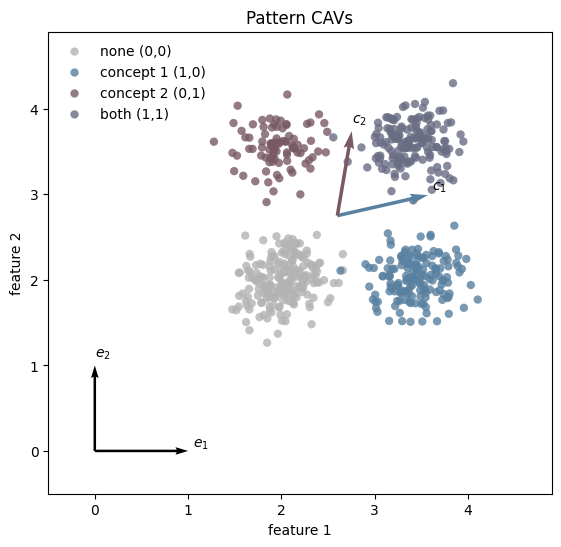

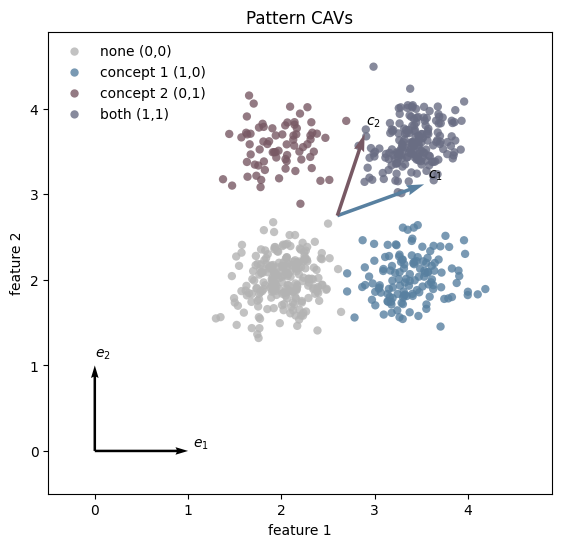

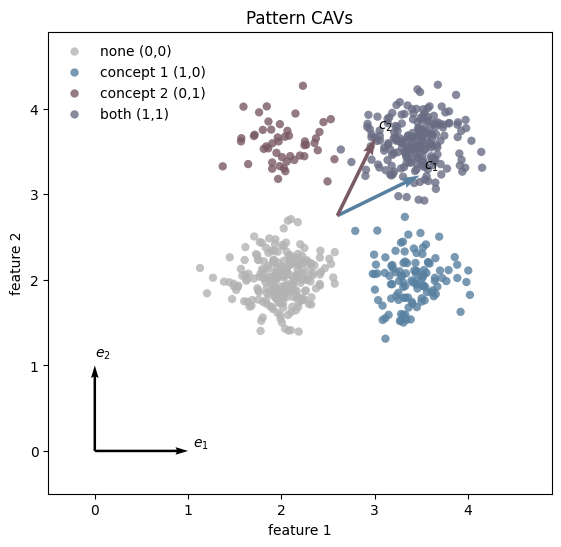

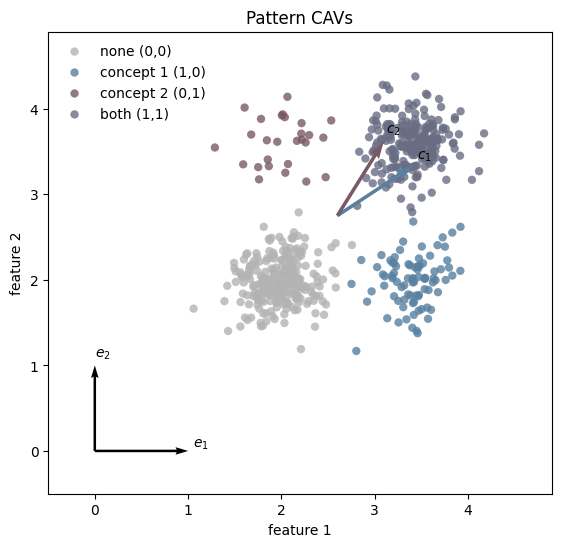

In [83]:
from utils.cav import compute_cavs

cross_correlations = [0.1, 0.3, 0.5, 0.7, 0.9]
save_dir = Path(Path.cwd().resolve().parent) / 'media' / 'cross_correlation_invariance'

for phi, toy in zip(cross_correlations, datasets):
    cavs_pattern, b_pattern = compute_cavs(toy.X, toy.Y, type="pattern_cav")
    visualize_toy_2d(toy, title="Pattern CAVs", scale=1, cavs=cavs_pattern, cav_pos=(2.6, 2.75), save_dir=save_dir, filename=f"pattern_cav:phi_{phi}.pdf")

### 2. Multi-Pattern CAV

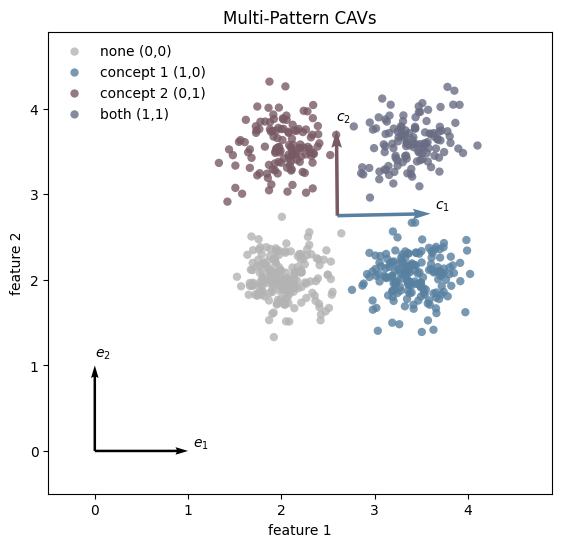

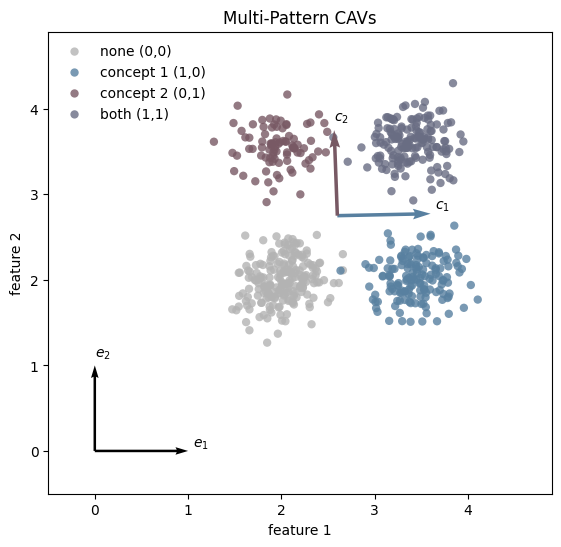

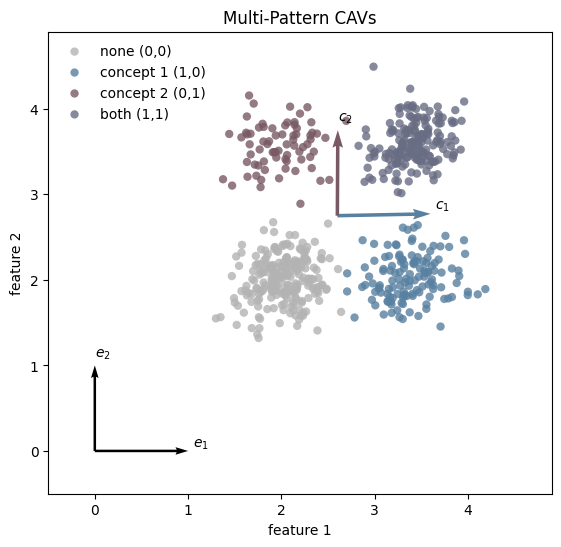

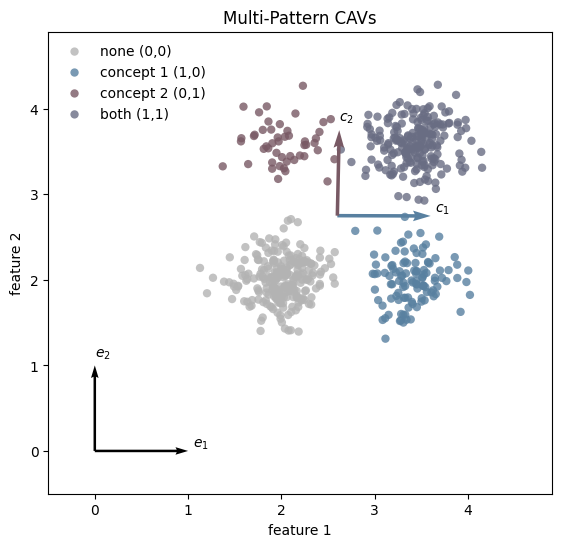

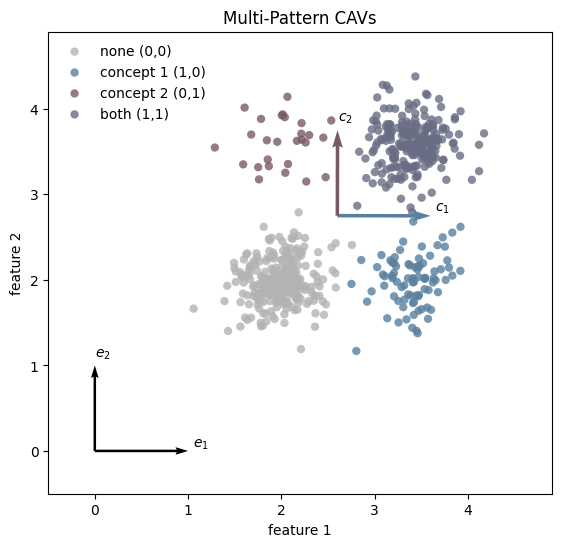

In [84]:
for phi, toy in zip(cross_correlations, datasets):
    cavs_multi, b_multi = compute_cavs(toy.X, toy.Y, type="multi_cav")
    visualize_toy_2d(toy, title="Multi-Pattern CAVs", scale=1, cavs=cavs_multi,cav_pos=(2.6, 2.75), save_dir=save_dir, filename=f"multi_cav:phi_{phi}.pdf")